## Курсовая работа по дисциплине "Численные Методы"
### Вычисление многократных интегралов с использованием метода Монте-Карло.
Сорокин Никита, М8О-403Б-20

In [40]:
import time
import numpy as np
from tqdm import tqdm

from scipy.special import gamma

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

### Интегрирование методом Монте-Карло

Рассмотрим

$$ I = \int_G f(x)dx, $$

где $ G $ - замкнутая область.

Пусть  

$$ G \subseteq [a_1, \, b_1] \times ... \times [a_m, \, b_m], $$

Проведем замену: 

$$
x \rightarrow \xi: \quad x_k = a_k + (b_k - a_k) \cdot \xi_k, \quad k = \overline{1, m}
$$

Замена переменных в интеграле приводит к умножению на Якобиан:

$$
\frac{D(x_1, ... x_m)}{D(\xi_1, ... \xi_m)} = \prod_{k=1}^{m} (b_k - a_k) = V,
$$

Введем вспомогательный интеграл:

$$
J := \int_{\Omega} f(x(\xi)) d \xi, \quad \Omega \subseteq [0, 1]^k, \quad I = V \cdot J
$$

Также вводим:

$$
F(\xi) := f(x(\xi))
$$

Берем равномерно распределенную случайную величину и определяем выборочное среднее для функции $ F(\xi) $:

$$
\xi \sim U([0, 1]^m), \quad \overline{F_n} := \frac{1}{n} \sum_{i=1}^{n} F(\xi_i)
$$

Отсюда получаем оценку интеграла $ J $:

$$
\hat{J} := \overline{F}_n \cdot \Omega
$$

Также воспользумся оценкой объема $ \Omega $:

$$
\hat{\Omega} := \frac{n}{N},
$$

где $ N $ - число сгенерированных точек, $ n $ - число точек, попавших в 

Таким образом, получаем оценку интеграла $ I $:

$$
\hat{I} = V \cdot \overline{F}_n \cdot \hat{\Omega} = \frac{V}{N} \sum_{i = 1}^{n} F(\xi_i)
$$


Получим формулу для оценки погрешности интегрирования:

$$
\Delta I = V \cdot (\Delta \overline{F} \cdot \hat{\Omega} + \Delta \Omega \cdot |\overline{F}_n|)
$$

Используя центральную предельную теорему и заменяя дисперсии на выборочные и выборочные несмещенные дисперсии получаем формулу вида:

$$ 
\Delta I = \frac{V \cdot t_\beta \cdot (S_1 \sqrt{\hat{\omega}} + | \overline{F_n}| S_2)}{\sqrt{N}}
$$

Реализация функции подсчета оценки интеграла Монте-Карло:

In [2]:
def MonteCarlo(f, cube, G, N, t_beta, large_numbers=False):

    V = np.prod(cube[:, 1] - cube[:, 0])

    if large_numbers == False:
        V = np.prod(cube[:, 1] - cube[:, 0])

    if large_numbers == True:
        V = int(1)
        for i in range(cube.shape[0]):
            V *= int(cube[i, 1] - cube[i, 0])

    xi = np.zeros((N, cube.shape[0]))
    for i in range(cube.shape[0]):
        xi[:, i] = np.random.random(N)

    x = np.zeros((N, cube.shape[0]))
    x = cube[:, 0] + (cube[:, 1] - cube[:, 0]) * xi

    n = 0
    F = np.zeros(N)
    F2 = np.zeros(N)
    for i in range(N):
        if G(x[i, :]) == 1:
            n += 1
            F[i] = f(x[i, :])
            F2[i] = f(x[i, :])**2

    omega_hat = n / N
    F_mean = np.sum(F) / n

    I_hat = V * F_mean * omega_hat

    S1 = np.sum(F2) / n - F_mean**2
    S2 = omega_hat * (1 - omega_hat)

    c = V * t_beta * (S1 * omega_hat**(0.5) + abs(F_mean) * S2)
    I_del = c / (N**(0.5))

    return I_hat, I_del, c

### Пример 1: Вычисление числа $ \pi $ с помощью гиперсфер разной размерности

Известно, что объем гиперсферы размерности $ n - 1 $ в пространстве размерности $ n $ можно найти по формуле:

$$
V_n = \frac{\pi^{\frac{n}{2}}}{\Gamma(\frac{n}{2} + 1)} \cdot R^n
$$

Выразим $ \pi $:

$$
\pi = \left( \frac{V_n \cdot \Gamma(\frac{n}{2} + 1)}{R^n} \right)^{2/n}
$$

Чтобы оценить это выражение будем искать $ V_n $ как интеграл вида:

$$
V_n = \int_{B_n} dx, \quad B_n = \{ x: |x| \leq R \}
$$

А уже сам интеграл будем искать оценкой монте карло, причем положим $ R = 1 $.

Визуализация в $ \mathbb{R}^2 $:

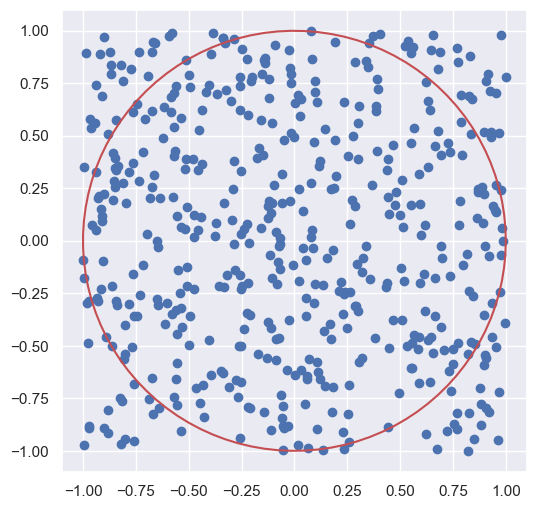

In [23]:
omega = np.array([[-1, 1], [-1, 1]])
N = 500

fig, axs = plt.subplots(figsize=(6, 6))

points = np.array([np.random.uniform(omega[:, 0], omega[:, 1]) for i in range(N)])
axs.scatter(points[:, 0], points[:, 1])

t = np.linspace(0, 2 * np.pi, 100)
axs.plot(np.cos(t), np.sin(t), c='r')

In [41]:
def f(x):
    return 1

def get_cube(n):
    return np.array([[-1, 1] for i in range(n)])

def G(x):
    return 1 if np.linalg.norm(x) <= 1 else 0

t_beta=3

def pi_estimate(V, n):
    return (V * gamma(n / 2 + 1))**(2 / n)

$ \mathbb{R}^2 $:

In [72]:
N = 10**6
n = 2
I_hat, I_del, c = MonteCarlo(f=f, cube=get_cube(n), G=G, N=N, t_beta=t_beta)

In [73]:
print(f'pi estimate in R^2: {pi_estimate(I_hat, n)}')
print(f'pi estimate error: {I_del}')

pi estimate in R^2: 3.139424
pi estimate error: 0.002026284711168


$ \mathbb{R}^3 $:

In [74]:
N = 10**6
n = 3
I_hat, I_del, c = MonteCarlo(f=f, cube=get_cube(n), G=G, N=N, t_beta=t_beta)

In [75]:
print(f'pi estimate in R^3: {pi_estimate(I_hat, n)}')
print(f'pi estimate error: {I_del}')

pi estimate in R^3: 3.1421655250815177
pi estimate error: 0.005986471618464


$ \mathbb{R}^4 $:

In [76]:
N = 10**6
n = 4
I_hat, I_del, c = MonteCarlo(f=f, cube=get_cube(n), G=G, N=N, t_beta=t_beta)

In [77]:
print(f'pi estimate in R^4: {pi_estimate(I_hat, n)}')
print(f'pi estimate error: {I_del}')

pi estimate in R^4: 3.1440101781005736
pi estimate error: 0.010247077920000002


$ \mathbb{R}^{100} $:

In [78]:
N = 10**6
n = 10
I_hat, I_del, c = MonteCarlo(f=f, cube=get_cube(n), G=G, N=N, t_beta=t_beta)

In [79]:
print(f'pi estimate in R^4: {pi_estimate(I_hat, n)}')
print(f'pi estimate error: {I_del}')

pi estimate in R^4: 3.1455200216326666
pi estimate error: 0.007679139729408


### Пример 2: Интеграл от функции, не имеющей первообразной в классе элементарных функций

$$ \Phi(t) = \frac{1}{\sqrt{2 \pi}} \int_0^t e^{-\frac{z}{2}}dz $$

По таблице Лапласа:

$ \Phi(3) = 0.49865 $ 

In [80]:
def f(x):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

cube = np.array([[0, 3]])

def G(x):
    return 1

t_beta=3

Монте Карло:

In [ ]:
N = 10**6
I_hat, I_del, c = MonteCarlo(f=f, cube=cube, G=G, N=N, t_beta=t_beta)

In [82]:
print(f'Monte Carlo estimate: {I_hat}')
print(f'Monte Carlo error: {I_del}')

Monte Carlo estimate: 0.49921483156120194
Monte Carlo error: 0.0001744773716132848


### Пример 3: Двойной интеграл

Вычислим методом Монте-Карло интеграл

$$ I = \int_0^2 dx \int_{x^2}^{2x} (x+y) dy $$

Нетрудно показать аналитически, что

$$ I = \frac{52}{15} = 3.4(6) $$

Область интегрирования:

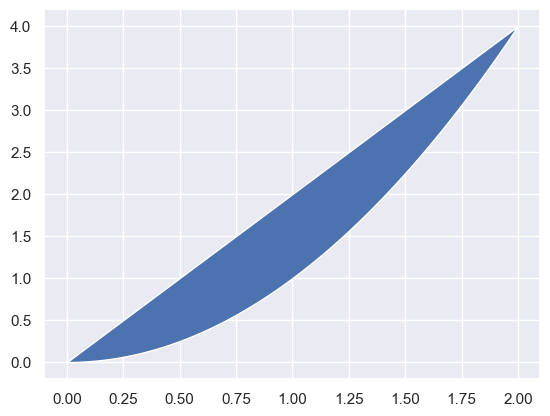

In [83]:
x = np.linspace(0, 2, 100)

y1 = lambda x: x**2
y2 = lambda x: 2 * x

plt.fill_between(x, y1(x), y2(x))

In [84]:
def f(x):
    return x[0] + x[1]

cube = np.array([[0, 2], [0, 4]])

def G(x):
    return 1 if (x[1] <= 2 * x[0]) and (x[1] >= x[0]**2) else 0

t_beta=3

In [86]:
N = 10**6
I_hat, I_del, c = MonteCarlo(f=f, cube=cube, G=G, N=N, t_beta=t_beta)

In [87]:
print(f'Monte Carlo estimate: {I_hat}')
print(f'Monte Carlo error: {I_del}')

Monte Carlo estimate: 3.463283471777522
Monte Carlo error: 0.027015317959454683


### Пример 4: Тройной интеграл. Объем восьмой части шара

Дан шар с центром в начале координат и радиусом R = 2. Вычислить методом Монте-Карло объем части шара, расположенной в первом октанте, т.е. вычислим тройной интеграл

$$ V = \int \int \int_G dx \, dy \, dz, $$

где $ G = \{(x, y, z): x^2 + y^2 + z^2 \leq 4, \, x \geq 0, \, y \geq 0, \, z \geq 0 \} $

Аналитическое значение равно:

$$ V = \frac{1}{8} \cdot \frac{4 \pi R^3}{3} = 4.18879020... $$

In [88]:
def f(x):
    return 1

cube = np.array([[-2, 2], [-2, 2], [-2, 2]])

def G(x):
    return 1 if (x[0]**2 + x[1]**2 + x[2]**2 <= 4) and (x[0] >= 0) and (x[1] >= 0) and (x[2] >= 0) else 0

t_beta=3

In [89]:
N = 10**6
I_hat, I_del, c = MonteCarlo(f=f, cube=cube, G=G, N=N, t_beta=t_beta)

In [90]:
print(f'Monte Carlo estimate: {I_hat}')
print(f'Monte Carlo error: {I_del}')

Monte Carlo estimate: 4.191808
Monte Carlo error: 0.011751771454272


### Пример 5: Шестикратные интегралы в задаче о взаимном притяжение двух материальных тел

Формула для силы взаимного притяжения двух материальных тел конечных размеров.



$$ F_x = G \iint \iint \limits_{D \times D'} \iint \frac{\rho(x,y,z) \rho'(x',y',z')}{r^3} \, (x-x') \, dx \, dy \, dz \, dx' dy' dz' $$

$$ F_y = G \iint \iint \limits_{D \times D'} \iint \frac{\rho(x,y,z) \rho'(x',y',z')}{r^3} \, (y-y') \, dx \, dy \, dz \, dx' dy' dz' $$

$$ F_z = G \iint \iint \limits_{D \times D'} \iint \frac{\rho(x,y,z) \rho'(x',y',z')}{r^3} \, (z-z') \, dx \, dy \, dz \, dx' dy' dz' $$

$$ F = \sqrt{F_x^{2} + F_y^{2} + F_z^{2}} $$

Используем данную модель для вычисления силы взаимного притяжения Луны и Земли. Для простоты предположим, что плотности Земли и Луны не зависят от координат и возьмем их средние значения.

In [91]:
G_const = 6.67 * 1e-11

m_earth = 6 * 10**24
m_moon = 7.35 * 10**22

r_const = 384467000

rho_earth = 5520
rho_moon = 3346

R_earth = 6367000
R_moon = 1737000

def r(x):
    return np.sqrt((x[0] - x[3])**2 + (x[1] - x[4])**2 + (x[2] - x[5])**2)

def fx(x):
    return G_const * rho_earth * rho_moon * (x[0] - x[3]) / r(x)**3

def fy(x):
    return G_const * rho_earth * rho_moon * (x[1] - x[4]) / r(x)**3

def fz(x):
    return G_const * rho_earth * rho_moon * (x[2] - x[5]) / r(x)**3

def f(fx, fy, fz):
    return np.sqrt(fx**2 + fy**2 + fz**2)

cube = np.array([[-R_earth, R_earth], [-R_earth, R_earth], [-R_earth, R_earth],
                 [r_const - R_moon, r_const + R_moon], [-R_moon, R_moon], [-R_moon, R_moon]])

def G(x):
    return 1 if ((x[0]**2 + x[1]**2 + x[2]**2 <= R_earth**2) and
                 ((x[3] - r_const)**2 + x[4]**2 + x[5]**2 <= R_moon**2)) else 0

t_beta=3

In [97]:
N = 10**6
Fx, Fx_del, c = MonteCarlo(f=fx, cube=cube, G=G, N=N, t_beta=t_beta, large_numbers=True)
Fy, Fy_del, c = MonteCarlo(f=fy, cube=cube, G=G, N=N, t_beta=t_beta, large_numbers=True)
Fz, Fz_del, c = MonteCarlo(f=fz, cube=cube, G=G, N=N, t_beta=t_beta, large_numbers=True)

In [98]:
print(f'Monte Carlo estimate: {f(Fx, Fy, Fz)}')
print(f'Monte Carlo error: {f(Fx_del, Fy_del, Fz_del)}')

Monte Carlo estimate: 1.978554236744114e+20
Monte Carlo error: 4.3080030888205715e+17


Принято использовать значение рассчитанное с допущением о том, что Земля и Луна являются материальными точками:

$$
F = \frac{G \cdot m_1 \cdot m_2}{r^2}
$$

Численное значение:

In [99]:
F = G_const * m_earth * m_moon / r_const**2
print(f'Analitical estimate: {F}')

Analitical estimate: 1.989968883800508e+20


### Вывод:

В ходе выполнения курсовой работы был реализован метод Монте Карло для интегрирования. Метод был опробован на многих примерах особый интерес представляет последний пример, который позволяет при должном желании повышать точность рассчета таких физических величин как сила взаимного притяжения небесных тел. Данный метод принято принимать, когда затруднительным местом в вычислениях становится размерность разбиваемого на сетку пространства (curse of dimensionality).